In [5]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import pandas as pd
import tensorflow as tf
from tqdm import tqdm , tqdm_notebook
import numpy as np
import category_encoders as ce
import re
from copy import deepcopy
from MI import Gene_Missing
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
RAW_ = pd.read_csv("/home/advice/Python/SR/Data/Churn.csv")
usecols = RAW_.columns.tolist()
notuse = ['account length' , 'phone number']
for col in notuse :
    usecols.remove(col)

In [7]:
RAW = RAW_[usecols]
RAW.shape

(3333, 19)

In [8]:
category = RAW.select_dtypes("object").columns.tolist() + ["area code" , "churn"]

In [9]:
RAW[category] = RAW[category].astype(str)

In [10]:
obj_col = RAW.select_dtypes("object").columns.tolist()
ord_col = RAW.select_dtypes("int").columns.tolist()
num_col = RAW.select_dtypes("float").columns.tolist()
print(obj_col)
assert len(usecols) == len(obj_col + ord_col + num_col)

['state', 'area code', 'international plan', 'voice mail plan', 'churn']


In [11]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
p_miss = 0.01
GMiss = Gene_Missing(RAW ,obj_col , ord_col , num_col , p_miss , minmax)
missing_RAW , missing_matrix_RAW = GMiss.generate(scale= True)
GMiss.save_info("AE_missing_info.pkl")
missing_info = GMiss.load_info("AE_missing_info.pkl")

AE_missing_info.pkl missing 정보 저장 완료


## 자체 결측 생성

In [12]:
##
RAW2 = RAW.values
RAW2[GMiss.ori_missing.astype(bool)] = np.nan
RAW3 = pd.DataFrame(RAW2, columns = usecols)
print(RAW3.dropna().shape)
RAW3.head(10)

(2700, 19)


,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,415,no,yes,25,265.1,110,45.07,197.4,99,NaN,244.7,91,11.01,10,3,2.7,1,False
1,OH,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False
2,NJ,415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,yes,no,0,299.4,71,50.9,61.9,NaN,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,yes,no,0,166.7,113,NaN,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.7,0,False
6,MA,510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,415,yes,no,0,157,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,415,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,NaN,False


In [13]:
RAW3.head()

,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,415,no,yes,25,265.1,110,45.07,197.4,99,NaN,244.7,91,11.01,10,3,2.7,1,False
1,OH,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False
2,NJ,415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,yes,no,0,299.4,71,50.9,61.9,NaN,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,yes,no,0,166.7,113,NaN,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [14]:
%load_ext autoreload
%autoreload 2
from MissInfo import MissInfo

missinfo = MissInfo(RAW3 , obj_col , num_col , ord_col , minmax)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
missinfo.fit()

Missing 정보 함축


In [16]:
trainX , testX , trainM , testM = missinfo.DL_train_test_split(0.7 , p_miss= 0.2 , numpy= True)

In [92]:
pd.DataFrame([np.sum(trainM , axis = 0) , np.sum(testM, axis = 0)])

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,...,366.0,356.0,404.0,353.0,360.0,376.0,381.0,400.0,356.0,356.0
1,170.0,170.0,170.0,170.0,170.0,170.0,170.0,170.0,170.0,170.0,...,172.0,182.0,182.0,176.0,152.0,139.0,147.0,164.0,181.0,181.0


In [17]:
trainX.shape , testX.shape , trainM.shape , testM.shape

((1889, 74), (811, 74), (1889, 74), (811, 74))

In [18]:
miss_info = missinfo.information()

In [19]:
print(list(miss_info.keys()))

['X', 'original_column', 'scaler', 'obj_col', 'ord_col', 'num_col', 'ce_replace', 'missing_matrix', 'ce_encoder', 'columns', 'obj_info', 'obj_range', 'cat_num_idx_info', 'ori_missing_matrix', 'ori_transform_missing_matrix', 'ori_raw_pd', 'ori_transform_pd']


In [20]:
print(miss_info["ori_raw_pd"].shape , miss_info["ori_missing_matrix"].shape )
print(miss_info["ori_transform_missing_matrix"].shape , miss_info["ori_transform_pd"].shape)

(2700, 19) (2700, 19)
(2700, 74) (2700, 74)


In [21]:
ck = missinfo.ori_missing[0,:].astype(bool)
missinfo.ori_raw_pd.loc[:,ck].head(1)

,state,voice mail plan,total intl charge
1,OH,yes,0.685185


In [23]:
ck = missinfo.ori_transform_missing[0,:].astype(bool)
missinfo.ori_transform_pd.loc[:,ck].head(1)

,state_KS,state_OH,state_NJ,state_OK,state_AL,state_MA,state_MO,state_LA,state_WV,state_IN,...,state_ME,state_MS,state_FL,state_TN,state_PA,state_CT,state_ND,voice mail plan_yes,voice mail plan_no,total intl charge
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.685185


In [93]:
%load_ext autoreload
%autoreload 2
from Tensorflow_AutoEncMI import Missing_AE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
Auto = Missing_AE(enc_dim = [50,30,10] , dec_dim= [20,30,60],
                  missing_info = miss_info , 
                  save_info_path= "./AE_missinfo.pkl" , 
                  save_model_path= './CAT_AE/Model' ) 

./AE_missinfo.pkl에 missing info 저장


In [95]:
mb_size = 64
Auto.fit(trainX , trainM ,testX , testM , mb_size , epoch = 3000)

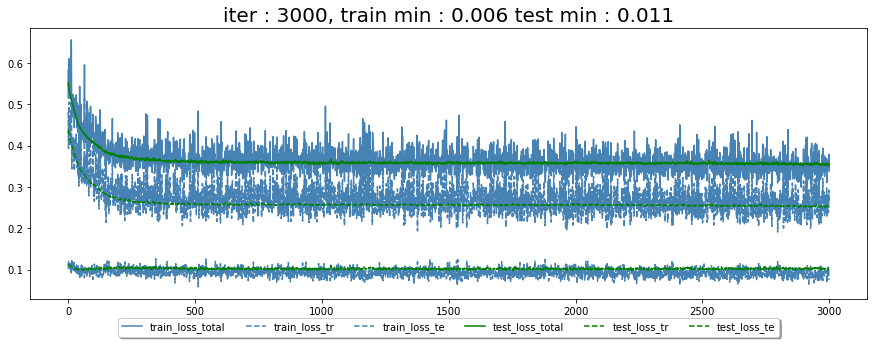

      학습완료 


In [96]:
Auto.train()

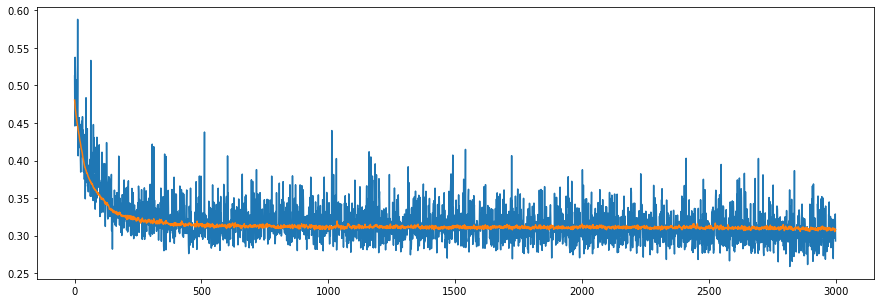

In [97]:
Auto.loss_plot()

In [98]:
missing_data = deepcopy(testX)
missing_data[testM == 1] = np.nan
result = Auto.impute(missing_data , testM , trans= True)

In [99]:
result.head(10)

,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,VA,415,no,no,0.000000,109.399995,103.735208,18.600000,101.299996,110.999998,8.610000,167.299997,106.000002,7.530000,7.800000,7.000000,2.110000,1.000000,False
1,TX,408,no,no,0.000000,157.899995,102.272031,26.840001,187.221492,132.000002,15.370000,132.500003,101.999998,5.960000,10.799133,3.000000,3.460000,1.000000,False
2,WV,415,no,no,0.000000,111.699998,121.000003,33.832113,237.299998,118.999998,20.169999,253.499998,109.999996,11.410000,13.099999,6.000000,2.660456,1.848537,False
3,WV,415,no,no,0.000000,181.876157,111.000002,21.880000,169.500000,104.000004,14.410000,193.600004,96.999999,8.710000,10.300000,5.000000,2.780000,1.000000,False
4,DE,415,yes,no,0.000000,188.643455,105.999997,25.500000,293.800002,122.999998,24.970001,250.700000,64.999999,11.280000,12.115866,5.940107,2.951359,0.710966,False
5,SC,415,no,yes,36.094032,146.599998,67.999999,24.919999,188.025862,67.000001,14.690000,193.687186,113.000003,9.795878,10.000000,2.000000,2.700000,1.000000,False
6,UT,415,no,no,0.000000,160.199998,116.999997,27.230000,267.499998,67.000001,22.739999,228.499989,68.000000,10.280000,9.300000,5.000000,2.510000,2.000000,False
7,WV,408,no,no,0.166811,206.000001,127.999996,35.019999,198.100007,98.892926,16.840000,135.900000,116.000001,6.120000,13.200001,3.000000,3.560000,0.000000,False
8,ID,415,no,no,7.089968,251.800003,72.000000,42.809999,205.699997,126.000003,17.480000,204.977000,109.000000,12.380000,9.800000,7.000000,2.650000,2.000000,True
9,NY,510,no,no,9.843308,171.478919,75.000002,32.610001,192.085171,134.999997,15.952765,193.751852,61.999999,9.020000,12.800000,3.000000,3.460000,2.000000,False


## Load Model

In [100]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [101]:
print(miss_info["ori_raw_pd"].shape , miss_info["ori_missing_matrix"].shape )
print(miss_info["ori_transform_missing_matrix"].shape , miss_info["ori_transform_pd"].shape)

(2700, 19) (2700, 19)
(2700, 74) (2700, 74)


In [102]:
missing_matrix_RAW = miss_info["ori_transform_missing_matrix"]
missing_RAW = miss_info["ori_transform_pd"]
missing_data = deepcopy(missing_RAW.values)
missing_data[missing_matrix_RAW == 1] = np.nan

In [103]:
pd.DataFrame(missing_data , columns= miss_info["columns"]).head()

,state_KS,state_OH,state_NJ,state_OK,state_AL,state_MA,state_MO,state_LA,state_WV,state_IN,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn_False,churn_True
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.53769,0.62184,0.492958,0.6,0.685,0.15,NaN,0.111111,1,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333225,NaN,0.5,0.338608,0.61,0.25,0.609259,0,1,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.6066,NaN,0.598592,0.456329,0.315,0.3,0.314815,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0.958266,0.509414,0.598592,0.481013,0.375,0.35,NaN,0.333333,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0.283403,0.507262,0.443662,NaN,0.355,0.3,0.355556,0,1,0


In [104]:
load_data = Auto.load_impute(save_file = './CAT_AE/Model.meta' , 
                 file= "./CAT_AE/" ,
                 Data = missing_data , 
                 Missing = missing_matrix_RAW
                )

In [105]:
load_data.head()

,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,ND,415,no,yes,26.000001,161.600002,123.000001,27.470000,195.500010,102.999999,16.619999,254.400001,102.999999,11.450000,13.7,3.0,2.942882,1.0,False
1,SC,415,no,no,0.000000,194.681980,113.999999,41.380001,190.820356,110.000004,10.300000,202.636044,104.000000,7.320000,12.2,5.0,3.290000,0.0,False
2,IL,415,yes,no,0.000000,223.399996,100.329625,37.979999,220.599994,100.999999,18.750000,184.247162,118.000002,9.180000,6.3,6.0,1.700000,0.0,False
3,MA,510,no,yes,24.000000,177.202382,96.783267,37.090000,348.499998,108.000004,29.620001,212.599999,118.000002,9.570000,7.5,7.0,2.878475,3.0,False
4,MO,415,yes,yes,11.509212,156.999996,99.291300,26.690000,103.100003,94.000005,8.760000,211.800008,95.999998,9.182126,7.1,6.0,1.920000,0.0,False


In [106]:
load_data.isna().sum().sum()

0

In [107]:
RAW_TRANS = Auto.transform(missing_RAW.values)

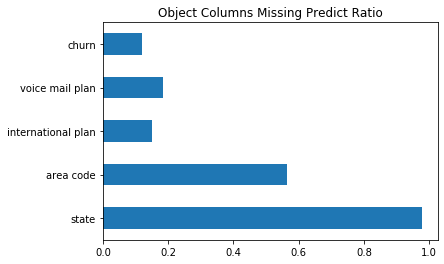

,N_not_correct,N_missing,Ratio
state,520,532.0,0.977444
area code,276,490.0,0.563265
international plan,79,528.0,0.149621
voice mail plan,101,550.0,0.183636
churn,64,537.0,0.119181


In [108]:
Auto.object_comparision(RAW_TRANS , load_data)

In [113]:
miss_info

dict_keys(['X', 'original_column', 'scaler', 'obj_col', 'ord_col', 'num_col', 'ce_replace', 'missing_matrix', 'ce_encoder', 'columns', 'obj_info', 'obj_range', 'cat_num_idx_info', 'ori_missing_matrix', 'ori_transform_missing_matrix', 'ori_raw_pd', 'ori_transform_pd'])